# 1. Import the module

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import copy       # helps to make copies instead of references
import time
from tqdm.auto import tqdm

random.seed(1)
food_label = {"0.Rice": 0, "1.Drink": 1, "2.Green Leaf Vegetables": 2, "3.Meat": 3, "4.Noodles": 4}

C:\Users\BiXY\anaconda3\envs\mmcv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Tagging a data set

['0.Rice', '1.Drink', '2.Green Leaf Vegetables', '3.Meat', '4.Noodles']
[tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [ 0.1765,  0.1922,  0.1922,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.2078,  0.2157,  0.2157,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.2235,  0.2471,  0.2392,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [ 0.0039,  0.0196,  0.0196,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.0275,  0.0353,  0.0431,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.0196,  0.0510,  0.0431,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, 

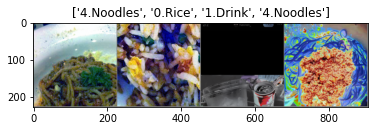

In [2]:
# class Food_Dataset(Dataset):
#     def __init__(self, data_dir, transform=None):
#         """
#         Datasets of Food classification
#         :param data_dir: str, path of food datasets
#         :param transform: torch.transform，data preprocessing
#         """
#         self.label_name = {"0.Rice": 0, "1.Drink": 1, "2.Green Leaf Vegetables": 2, "3.Meat": 3, "4.Noodles": 4}
#         self.data_info = self.get_img_info(data_dir)  # data_info stores the path and the label of every photo,and read samples by index in Dataloader
#         self.transform = transform                     

#     def __getitem__(self, index):
#         path_img, label = self.data_info[index]
#         img = Image.open(path_img).convert('RGB')     # 0~255

#         if self.transform is not None:
#             img = self.transform(img)   # perform transformation here,to tensor and so on

#         return img, label

#     def __len__(self):
#         return len(self.data_info)

#     @staticmethod
#     def get_img_info(data_dir):
#         data_info = list()
#         for root, dirs, _ in os.walk(data_dir):
#             # visit each class
#             for sub_dir in dirs:
#                 img_names = os.listdir(os.path.join(root, sub_dir))
#                 img_names = list(filter(lambda x: x.endswith('.jpg'), img_names))

#                 # visit each photo
#                 for i in range(len(img_names)):
#                     img_name = img_names[i]
#                     path_img = os.path.join(root, sub_dir, img_name)
#                     label = food_label[sub_dir]
#                     data_info.append((path_img, int(label)))

#         return data_info
#
# food_dataset = Food_Dataset(r'C:\Users\BiXY\OneDrive - 厦门大学(马来西亚分校)\AIT202\Project\Food_Dataset')

# transform setting
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

data_transform = {
    'train': transforms.Compose([
        transforms.AutoAugment(),
        transforms.RandomResizedCrop(224), # 224 x 224 shrink the picture
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Normalize to [0.0,1.0]
        transforms.Normalize(mean, std) # transform every number in the tensor to be in the range of [-1,1]
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224), # crop it from the middle
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224), # crop it from the middle
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}


batch_size = 4
data_dir = r'.\Food_Dataset_split'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(class_names)

def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    img = std*img + mean
    plt.imshow(img)
    plt.title(title)
    plt.show()

inputs, classes = next(iter(dataloaders['train']))
print(next(iter(dataloaders['train'])))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 3. Build the Model

In [3]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # channel = 3, 5x5, filter num: 6 stride = 1
        self.pool = nn.MaxPool2d(2, 2)  # size, stride=2(shrunk it half)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(44944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        # n, 3, 32, 32
        x = self.conv1(x)  # n, 6, 28, 28
        x = F.relu(x)
        x = self.pool(x)  # n, 6, 14, 14
        x = self.conv2(x)  # n, 16, 10, 10
        x = F.relu(x)
        x = self.pool(x)  # n, 16, 5, 5
        x = x.view(-1, 44944)  # n, 400, -1 is batches
        x = self.fc1(x)  # n, 120
        x = F.relu(x)
        x = self.fc2(x)  # n, 84
        x = F.relu(x)
        x = self.fc3(x)  # n, 10
        return x

In [4]:
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class BasicBlock_moveBN(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock_moveBN, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# class Bottleneck(nn.Module):
#     expansion = 4

#     def __init__(self, in_planes, planes, stride=1):
#         super(Bottleneck, self).__init__()
#         self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)
#         self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
#         self.bn3 = nn.BatchNorm2d(self.expansion * planes)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion * planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion * planes)
#             )

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = F.relu(self.bn2(self.conv2(out)))
#         out = self.bn3(self.conv3(out))
#         out += self.shortcut(x)
#         out = F.relu(out)
#         return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=5):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(25088 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


class ResNet_moveBN(nn.Module):
    def __init__(self, block, num_blocks, num_classes=5):
        super(ResNet_moveBN, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(25088 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
def ResNet18_original():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet18_move_BN():
    return ResNet_moveBN(BasicBlock_moveBN, [2, 2, 2, 2])

def ResNet34_original():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet34_move_BN():
    return ResNet_moveBN(BasicBlock_moveBN, [3, 4, 6, 3])

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


# def test():
#     net = ResNet18()
#     y = net(torch.randn(1, 3, 32, 32))
#     print(y.size())

In [46]:
from collections import OrderedDict

# regard one convolutional layer as a basic conv
class BasicConv2d(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride=1, padding=0):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Sequential(OrderedDict([
            ('Conv', nn.Conv2d(in_channel, out_channel, kernel_size,
                      stride=stride, padding=padding, bias=False)),
            ('BN', nn.BatchNorm2d(out_channel))]
        ))


    def forward(self, x):
        x = self.conv(x)
        return x

# one bottleneck module:
class Bottleneck(nn.Module):
    def __init__(self, in_channel, mid_channel, out_channel, stride=1):
        super(Bottleneck, self).__init__()

        self.judge = in_channel == out_channel

        self.bottleneck = nn.Sequential(OrderedDict([
            ('Conv1',BasicConv2d(in_channel, mid_channel, 1)),
            ('Relu1',nn.ReLU(True)),
            ('Conv2',BasicConv2d(mid_channel, mid_channel, 3, padding=1, stride=stride)),
            ('Relu2',nn.ReLU(True)),
            ('Conv3',BasicConv2d(mid_channel, out_channel, 1)),]
        ))
        self.relu = nn.ReLU(True)
        # here we use linear projection to match dimensions by an 1x1 convolutional layer
        if in_channel != out_channel:
            self.projection = BasicConv2d(
                in_channel, out_channel, 1, stride=stride)

    def forward(self, x):
        out = self.bottleneck(x)
        # perform projection on the residual by an 1x1 convolutional layer if input channel doesn't equal output channel
        if not self.judge:
            self.shortcut = self.projection(x)
            # out += projection of residual
            out += self.shortcut
        # otherwise, add them together directly
        else:
            out += x

        out = self.relu(out)

        return out

# Resnet50:
class ResNet_50_original(nn.Module):
    def __init__(self, class_num):
        super(ResNet_50_original, self).__init__()
        self.conv = BasicConv2d(3, 64, 7, stride=2, padding=3)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        # convolutional block 1
        self.block1 = nn.Sequential(
            Bottleneck(64, 64, 256),
            Bottleneck(256, 64, 256),
            Bottleneck(256, 64, 256),
        )
        # convolutional block 2
        self.block2 = nn.Sequential(
            Bottleneck(256, 128, 512, stride=2),
            Bottleneck(512, 128, 512),
            Bottleneck(512, 128, 512),
            Bottleneck(512, 128, 512),
        )
        # convolutional block 3
        self.block3 = nn.Sequential(
            Bottleneck(512, 256, 1024, stride=2),
            Bottleneck(1024, 256, 1024),
            Bottleneck(1024, 256, 1024),
            Bottleneck(1024, 256, 1024),
            Bottleneck(1024, 256, 1024),
            Bottleneck(1024, 256, 1024),
        )
        # convolutional block 4
        self.block4 = nn.Sequential(
            Bottleneck(1024, 512, 2048, stride=2),
            Bottleneck(2048, 512, 2048),
            Bottleneck(2048, 512, 25088),
        )
        self.avgpool = nn.AvgPool2d(4)
        self.classifier = nn.Linear(25088, class_num)

    def forward(self, x):
        x = self.conv(x)
        x = self.maxpool(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        out = self.classifier(x)

        return out

In [17]:
from collections import OrderedDict

#regard one convolutional layer as a basic conv
class BasicConv2d_moveBN(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride=1, padding=0):
        super(BasicConv2d_moveBN, self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size,
                      stride=stride, padding=padding, bias=False)

    def forward(self, x):
        x = self.conv(x)
        return x
    
# one bottleneck
class Bottleneck_moveBN(nn.Module):
    def __init__(self, in_channel, mid_channel, out_channel, stride=1):
        super(Bottleneck_moveBN, self).__init__()

        self.judge = in_channel == out_channel

        self.bottleneck = nn.Sequential(OrderedDict([
            ('Conv1',BasicConv2d_moveBN(in_channel, mid_channel, 1)),
            ('Relu1',nn.ReLU(True)),
            ('Conv2',BasicConv2d_moveBN(mid_channel, mid_channel, 3, padding=1, stride=stride)),
            ('Relu2',nn.ReLU(True)),
            ('Conv3',BasicConv2d_moveBN(mid_channel, out_channel, 1)),]
        ))
        self.relu = nn.ReLU(True)
        # here we use linear projection to match dimensions by an 1x1 convolutional layer
        if in_channel != out_channel:
            self.projection = BasicConv2d_moveBN(
                in_channel, out_channel, 1, stride=stride)

    def forward(self, x):
        out = self.bottleneck(x)
        # perform projection on the residual by an 1x1 convolutional layer if input channel doesn't equal output channel
        if not self.judge:
            self.shortcut = self.projection(x)
            # out += projection of residual
            out += self.shortcut
        # otherwise, add them together directly
        else:
            out += x

        out = self.relu(out)

        return out

# Modified Resnet50:
class ResNet_50_modified(nn.Module):
    def __init__(self, class_num):
        super(ResNet_50_modified, self).__init__()
        self.conv = BasicConv2d_moveBN(3, 64, 7, stride=2, padding=3)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        # convolutional block 1
        self.block1 = nn.Sequential(
            Bottleneck_moveBN(64, 64, 256),
            Bottleneck_moveBN(256, 64, 256),
            Bottleneck_moveBN(256, 64, 256),
        )
        # convolutional block 2
        self.block2 = nn.Sequential(
            Bottleneck_moveBN(256, 128, 512, stride=2),
            Bottleneck_moveBN(512, 128, 512),
            Bottleneck_moveBN(512, 128, 512),
            Bottleneck_moveBN(512, 128, 512),
        )
        self.avgpool = nn.AvgPool2d(4)
        self.classifier = nn.Linear(25088, class_num)

    def forward(self, x):
        x = self.conv(x)
        x = self.maxpool(x)
        x = self.block1(x)
        x = self.block2(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        out = self.classifier(x)

        return out

# 3.1 Model: Original ResNet34

In [6]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
# model = ResNet_34(5).to(device)
# model = ResNet18_original().to(device)
model = ResNet34_original().to(device)

In [7]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [8]:
# The number of training epochs.
n_epochs = 20
t_loss1 = []
t_acc1 = []
v_loss1 = []
v_acc1 = []
for epoch in range(n_epochs):
# Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    
    # Iterate the training set by batches.
    for batch in tqdm(dataloaders['train']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    t_loss1.append(train_loss)
    t_acc1.append(train_acc)
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    # Iterate the validation set by batches.
    for batch in tqdm(dataloaders['valid']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    v_loss1.append(valid_loss)
    v_acc1.append(valid_acc)
    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:23<00:00,  2.24it/s]


[ Train | 001/020 ] loss = 4.97911, acc = 0.18750


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.59it/s]


[ Valid | 001/020 ] loss = 24.11076, acc = 0.26000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:17<00:00,  2.42it/s]


[ Train | 002/020 ] loss = 1.82559, acc = 0.21144


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.49it/s]


[ Valid | 002/020 ] loss = 3.41915, acc = 0.22500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:20<00:00,  2.35it/s]


[ Train | 003/020 ] loss = 1.67733, acc = 0.24468


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.63it/s]


[ Valid | 003/020 ] loss = 1.88551, acc = 0.24000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:19<00:00,  2.35it/s]


[ Train | 004/020 ] loss = 1.64731, acc = 0.23803


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.52it/s]


[ Valid | 004/020 ] loss = 11.31241, acc = 0.31500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:19<00:00,  2.37it/s]


[ Train | 005/020 ] loss = 1.63349, acc = 0.22606


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.78it/s]


[ Valid | 005/020 ] loss = 1.84811, acc = 0.35000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:19<00:00,  2.36it/s]


[ Train | 006/020 ] loss = 1.61323, acc = 0.22074


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.53it/s]


[ Valid | 006/020 ] loss = 2.25521, acc = 0.25000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:19<00:00,  2.37it/s]


[ Train | 007/020 ] loss = 1.66749, acc = 0.23537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.63it/s]


[ Valid | 007/020 ] loss = 1.82927, acc = 0.22000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:21<00:00,  2.30it/s]


[ Train | 008/020 ] loss = 1.64947, acc = 0.21809


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.51it/s]


[ Valid | 008/020 ] loss = 1.59697, acc = 0.23000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.39it/s]


[ Train | 009/020 ] loss = 1.63791, acc = 0.22872


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.64it/s]


[ Valid | 009/020 ] loss = 3.12067, acc = 0.22500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:20<00:00,  2.33it/s]


[ Train | 010/020 ] loss = 1.63812, acc = 0.22074


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.67it/s]


[ Valid | 010/020 ] loss = 1.58249, acc = 0.30000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.38it/s]


[ Train | 011/020 ] loss = 1.63364, acc = 0.22473


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.57it/s]


[ Valid | 011/020 ] loss = 2.02183, acc = 0.29000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:20<00:00,  2.34it/s]


[ Train | 012/020 ] loss = 1.60593, acc = 0.23537


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]


[ Valid | 012/020 ] loss = 1.88167, acc = 0.25500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:19<00:00,  2.36it/s]


[ Train | 013/020 ] loss = 1.68763, acc = 0.23138


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.56it/s]


[ Valid | 013/020 ] loss = 2.86833, acc = 0.27000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:20<00:00,  2.33it/s]


[ Train | 014/020 ] loss = 1.71169, acc = 0.21809


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.26it/s]


[ Valid | 014/020 ] loss = 1.64759, acc = 0.27500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:20<00:00,  2.32it/s]


[ Train | 015/020 ] loss = 1.61505, acc = 0.24601


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.46it/s]


[ Valid | 015/020 ] loss = 1.54813, acc = 0.29000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:22<00:00,  2.28it/s]


[ Train | 016/020 ] loss = 1.59703, acc = 0.25931


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.28it/s]


[ Valid | 016/020 ] loss = 4.99056, acc = 0.22000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:19<00:00,  2.37it/s]


[ Train | 017/020 ] loss = 1.58873, acc = 0.26596


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


[ Valid | 017/020 ] loss = 1.41506, acc = 0.42500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:21<00:00,  2.30it/s]


[ Train | 018/020 ] loss = 1.56723, acc = 0.29787


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.44it/s]


[ Valid | 018/020 ] loss = 1.43127, acc = 0.41500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:19<00:00,  2.37it/s]


[ Train | 019/020 ] loss = 1.53710, acc = 0.29122


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.61it/s]


[ Valid | 019/020 ] loss = 1.54415, acc = 0.28000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:20<00:00,  2.33it/s]


[ Train | 020/020 ] loss = 1.53060, acc = 0.28856


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.33it/s]

[ Valid | 020/020 ] loss = 1.70554, acc = 0.37500


In [9]:
model.eval()
predictions = []

image_datasets_test = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform['test']) for x in ["test"]}
dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets_test[x],  batch_size=batch_size, shuffle=False) for x in ["test"]}
datasets_sizes_test = {x: len(image_datasets_test[x]) for x in ["test"]}

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(5)]
    n_class_samples = [0 for i in range(5)]
    for batch in tqdm(dataloaders_test['test']):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        _, predicted = torch.max(logits, 1) # 1d output
        n_samples += labels.size(0) # +4 cause batch_size
        n_correct += (predicted == labels).sum()
        for i in range(images.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
            predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    acc = 100.0 * n_correct / n_samples
    print(f"Accuracy of the network: {acc} %")
    
    for i in range(5):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {image_datasets_test["test"].classes[i]}: {acc} % ' )

# # Make sure the model is in eval mode.
# # Some modules like Dropout or BatchNorm affect if the model is in training mode.

#
# Initialize a list to store the predictions.
model.eval()
predictions = []

# Iterate the testing set by batches.

    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    
#     # Take the class with greatest logit as prediction and record it.
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.91it/s]

Accuracy of the network: 32.5 %
Accuracy of 0.Rice: 30.0 % 
Accuracy of 1.Drink: 82.5 % 
Accuracy of 2.Green Leaf Vegetables: 40.0 % 
Accuracy of 3.Meat: 2.5 % 
Accuracy of 4.Noodles: 7.5 % 


# 3.2 Model: Original ResNet50

In [47]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = ResNet_50_original(5).to(device)
# model = ResNet18_original().to(device)
# model = ResNet34_original().to(device)
# model = ResNet34_move_BN().to(device)

In [48]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [49]:
# The number of training epochs.
n_epochs = 20
t_loss2 = []
t_acc2 = []
v_loss2 = []
v_acc2 = []
for epoch in range(n_epochs):
# Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    
    # Iterate the training set by batches.
    for batch in tqdm(dataloaders['train']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    t_loss2.append(train_loss)
    t_acc2.append(train_acc)
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    # Iterate the validation set by batches.
    for batch in tqdm(dataloaders['valid']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    v_loss2.append(valid_loss)
    v_acc2.append(valid_acc)
    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:22<00:00,  2.28it/s]


[ Train | 001/020 ] loss = 3.41455, acc = 0.20612


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.66it/s]


[ Valid | 001/020 ] loss = 5.60686, acc = 0.22500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:40<00:00,  1.87it/s]


[ Train | 002/020 ] loss = 1.81963, acc = 0.15957


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.83it/s]


[ Valid | 002/020 ] loss = 1.61678, acc = 0.14000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [02:14<00:00,  1.39it/s]


[ Train | 003/020 ] loss = 1.77135, acc = 0.21277


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.66it/s]


[ Valid | 003/020 ] loss = 1.93917, acc = 0.22000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:53<00:00,  1.65it/s]


[ Train | 004/020 ] loss = 1.81312, acc = 0.20479


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.02it/s]


[ Valid | 004/020 ] loss = 1.69955, acc = 0.32000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:54<00:00,  1.64it/s]


[ Train | 005/020 ] loss = 1.67283, acc = 0.18750


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.52it/s]


[ Valid | 005/020 ] loss = 1.61296, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [02:04<00:00,  1.51it/s]


[ Train | 006/020 ] loss = 1.62880, acc = 0.19947


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.07it/s]


[ Valid | 006/020 ] loss = 1.66476, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:58<00:00,  1.59it/s]


[ Train | 007/020 ] loss = 1.63836, acc = 0.19415


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.08it/s]


[ Valid | 007/020 ] loss = 1.61580, acc = 0.22000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:51<00:00,  1.69it/s]


[ Train | 008/020 ] loss = 1.61539, acc = 0.21809


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.88it/s]


[ Valid | 008/020 ] loss = 1.57662, acc = 0.25500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [02:12<00:00,  1.42it/s]


[ Train | 009/020 ] loss = 1.74861, acc = 0.20878


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.01it/s]


[ Valid | 009/020 ] loss = 1.61955, acc = 0.21000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [02:11<00:00,  1.43it/s]


[ Train | 010/020 ] loss = 1.87358, acc = 0.20479


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.06it/s]


[ Valid | 010/020 ] loss = 1.61626, acc = 0.23000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [02:07<00:00,  1.48it/s]


[ Train | 011/020 ] loss = 1.79688, acc = 0.20213


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.69it/s]


[ Valid | 011/020 ] loss = 1.60672, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [02:08<00:00,  1.46it/s]


[ Train | 012/020 ] loss = 1.62099, acc = 0.21011


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:20<00:00,  2.42it/s]


[ Valid | 012/020 ] loss = 1.60677, acc = 0.19000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [02:18<00:00,  1.36it/s]


[ Train | 013/020 ] loss = 1.62433, acc = 0.18883


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.87it/s]


[ Valid | 013/020 ] loss = 1.61298, acc = 0.23500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [02:00<00:00,  1.56it/s]


[ Train | 014/020 ] loss = 1.61530, acc = 0.18351


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.71it/s]


[ Valid | 014/020 ] loss = 1.59752, acc = 0.24500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [02:25<00:00,  1.29it/s]


[ Train | 015/020 ] loss = 1.61054, acc = 0.19681


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.82it/s]


[ Valid | 015/020 ] loss = 1.60891, acc = 0.21000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [02:39<00:00,  1.18it/s]


[ Train | 016/020 ] loss = 1.65495, acc = 0.21410


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.58it/s]


[ Valid | 016/020 ] loss = 1.62741, acc = 0.22000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [02:55<00:00,  1.07it/s]


[ Train | 017/020 ] loss = 1.61260, acc = 0.19814


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.37it/s]


[ Valid | 017/020 ] loss = 1.57619, acc = 0.35500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [02:55<00:00,  1.07it/s]


[ Train | 018/020 ] loss = 1.69944, acc = 0.20745


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.59it/s]


[ Valid | 018/020 ] loss = 1.57987, acc = 0.30000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [02:53<00:00,  1.08it/s]


[ Train | 019/020 ] loss = 1.64428, acc = 0.18617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.64it/s]


[ Valid | 019/020 ] loss = 1.60693, acc = 0.24500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [02:52<00:00,  1.09it/s]


[ Train | 020/020 ] loss = 1.61675, acc = 0.21410


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.63it/s]

[ Valid | 020/020 ] loss = 1.58982, acc = 0.22500


In [21]:
model.eval()
predictions = []

image_datasets_test = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform['test']) for x in ["test"]}
dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets_test[x],  batch_size=batch_size, shuffle=False) for x in ["test"]}
datasets_sizes_test = {x: len(image_datasets_test[x]) for x in ["test"]}

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(5)]
    n_class_samples = [0 for i in range(5)]
    for batch in tqdm(dataloaders_test['test']):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        _, predicted = torch.max(logits, 1) # 1d output
        n_samples += labels.size(0) # +4 cause batch_size
        n_correct += (predicted == labels).sum()
        for i in range(images.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
            predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    acc = 100.0 * n_correct / n_samples
    print(f"Accuracy of the network: {acc} %")
    
    for i in range(5):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {image_datasets_test["test"].classes[i]}: {acc} % ' )

# # Make sure the model is in eval mode.
# # Some modules like Dropout or BatchNorm affect if the model is in training mode.

#
# # Initialize a list to store the predictions.

#
# # Iterate the testing set by batches.

    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
#
    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    
#     # Take the class with greatest logit as prediction and record it.
    
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.39it/s]

Accuracy of the network: 20.0 %
Accuracy of 0.Rice: 0.0 % 
Accuracy of 1.Drink: 100.0 % 
Accuracy of 2.Green Leaf Vegetables: 0.0 % 
Accuracy of 3.Meat: 0.0 % 
Accuracy of 4.Noodles: 0.0 % 


# 3.3 Model: Move the BatchNorm layer ResNet34

In [22]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
# model = ResNet_34(5).to(device)
# model = ResNet18_original().to(device)
# model = ResNet34_original().to(device)
model = ResNet34_move_BN().to(device)

In [23]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [24]:
# The number of training epochs.
n_epochs = 20
t_loss3 = []
t_acc3 = []
v_loss3 = []
v_acc3 = []
for epoch in range(n_epochs):
# Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    
    # Iterate the training set by batches.
    for batch in tqdm(dataloaders['train']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    t_loss3.append(train_loss)
    t_acc3.append(train_acc)
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    # Iterate the validation set by batches.
    for batch in tqdm(dataloaders['valid']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    v_loss3.append(valid_loss)
    v_acc3.append(valid_acc)
    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:11<00:00,  2.63it/s]


[ Train | 001/020 ] loss = 12.21982, acc = 0.18351


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.82it/s]


[ Valid | 001/020 ] loss = 1.60945, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.50it/s]


[ Train | 002/020 ] loss = 1.61175, acc = 0.19415


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.65it/s]


[ Valid | 002/020 ] loss = 1.60945, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:13<00:00,  2.54it/s]


[ Train | 003/020 ] loss = 1.61869, acc = 0.19149


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.55it/s]


[ Valid | 003/020 ] loss = 1.60946, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.50it/s]


[ Train | 004/020 ] loss = 1.60982, acc = 0.18484


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.81it/s]


[ Valid | 004/020 ] loss = 1.60945, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:13<00:00,  2.55it/s]


[ Train | 005/020 ] loss = 1.60976, acc = 0.19149


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.67it/s]


[ Valid | 005/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.53it/s]


[ Train | 006/020 ] loss = 1.60994, acc = 0.16090


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.76it/s]


[ Valid | 006/020 ] loss = 1.60945, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:13<00:00,  2.55it/s]


[ Train | 007/020 ] loss = 1.60979, acc = 0.18218


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.48it/s]


[ Valid | 007/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.50it/s]


[ Train | 008/020 ] loss = 1.60997, acc = 0.18085


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.97it/s]


[ Valid | 008/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:12<00:00,  2.60it/s]


[ Train | 009/020 ] loss = 1.60992, acc = 0.18351


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.60it/s]


[ Valid | 009/020 ] loss = 1.60945, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.47it/s]


[ Train | 010/020 ] loss = 1.60995, acc = 0.16888


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.54it/s]


[ Valid | 010/020 ] loss = 1.60945, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:13<00:00,  2.55it/s]


[ Train | 011/020 ] loss = 1.60989, acc = 0.18085


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.72it/s]


[ Valid | 011/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:16<00:00,  2.46it/s]


[ Train | 012/020 ] loss = 1.75546, acc = 0.17287


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.91it/s]


[ Valid | 012/020 ] loss = 1.60943, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.54it/s]


[ Train | 013/020 ] loss = 3.12254, acc = 0.19681


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.84it/s]


[ Valid | 013/020 ] loss = 1.60945, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.52it/s]


[ Train | 014/020 ] loss = 1.60979, acc = 0.16356


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.75it/s]


[ Valid | 014/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:12<00:00,  2.59it/s]


[ Train | 015/020 ] loss = 1.60981, acc = 0.18351


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.81it/s]


[ Valid | 015/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:13<00:00,  2.54it/s]


[ Train | 016/020 ] loss = 1.60976, acc = 0.18617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.76it/s]


[ Valid | 016/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:12<00:00,  2.59it/s]


[ Train | 017/020 ] loss = 1.60987, acc = 0.15293


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.59it/s]


[ Valid | 017/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.50it/s]


[ Train | 018/020 ] loss = 1.60983, acc = 0.18351


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.62it/s]


[ Valid | 018/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:16<00:00,  2.45it/s]


[ Train | 019/020 ] loss = 2.97419, acc = 0.17021


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.51it/s]


[ Valid | 019/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:13<00:00,  2.55it/s]


[ Train | 020/020 ] loss = 1.61001, acc = 0.17287


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.62it/s]

[ Valid | 020/020 ] loss = 1.60944, acc = 0.20000


In [25]:
model.eval()
predictions = []

image_datasets_test = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform['test']) for x in ["test"]}
dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets_test[x],  batch_size=batch_size, shuffle=False) for x in ["test"]}
datasets_sizes_test = {x: len(image_datasets_test[x]) for x in ["test"]}

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(5)]
    n_class_samples = [0 for i in range(5)]
    for batch in tqdm(dataloaders_test['test']):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        _, predicted = torch.max(logits, 1) # 1d output
        n_samples += labels.size(0) # +4 cause batch_size
        n_correct += (predicted == labels).sum()
        for i in range(images.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
            predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    acc = 100.0 * n_correct / n_samples
    print(f"Accuracy of the network: {acc} %")
    
    for i in range(5):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {image_datasets_test["test"].classes[i]}: {acc} % ' )

# # Make sure the model is in eval mode.
# # Some modules like Dropout or BatchNorm affect if the model is in training mode.

#
# # Initialize a list to store the predictions.

#
# # Iterate the testing set by batches.

    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
#
    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    
#     # Take the class with greatest logit as prediction and record it.
    
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.16it/s]

Accuracy of the network: 20.0 %
Accuracy of 0.Rice: 0.0 % 
Accuracy of 1.Drink: 100.0 % 
Accuracy of 2.Green Leaf Vegetables: 0.0 % 
Accuracy of 3.Meat: 0.0 % 
Accuracy of 4.Noodles: 0.0 % 


# 3.4 Model: Original ResNet18

In [26]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
# model = ResNet_50(5).to(device)
model = ResNet18_original().to(device)
# model = ResNet34_original().to(device)
# model = ResNet34_move_BN().to(device)
# model = ResNet18_move_BN().to(device)

In [27]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [28]:
# The number of training epochs.
n_epochs = 20
t_loss4 = []
t_acc4 = []
v_loss4 = []
v_acc4 = []
for epoch in range(n_epochs):
# Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    
    # Iterate the training set by batches.
    for batch in tqdm(dataloaders['train']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    t_loss4.append(train_loss)
    t_acc4.append(train_acc)
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    # Iterate the validation set by batches.
    for batch in tqdm(dataloaders['valid']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    v_loss4.append(valid_loss)
    v_acc4.append(valid_acc)
    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.10it/s]


[ Train | 001/020 ] loss = 5.19861, acc = 0.18351


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.32it/s]


[ Valid | 001/020 ] loss = 3.34187, acc = 0.24500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:01<00:00,  3.06it/s]


[ Train | 002/020 ] loss = 1.72293, acc = 0.21277


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.48it/s]


[ Valid | 002/020 ] loss = 1.65028, acc = 0.33000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.97it/s]


[ Train | 003/020 ] loss = 1.66401, acc = 0.20745


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.28it/s]


[ Valid | 003/020 ] loss = 2.98003, acc = 0.32500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.09it/s]


[ Train | 004/020 ] loss = 1.61357, acc = 0.25000


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.29it/s]


[ Valid | 004/020 ] loss = 1.99775, acc = 0.32000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:02<00:00,  3.00it/s]


[ Train | 005/020 ] loss = 1.59540, acc = 0.25266


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.02it/s]


[ Valid | 005/020 ] loss = 1.52325, acc = 0.35500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:01<00:00,  3.08it/s]


[ Train | 006/020 ] loss = 1.74398, acc = 0.25532


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.31it/s]


[ Valid | 006/020 ] loss = 16.51972, acc = 0.32000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.09it/s]


[ Train | 007/020 ] loss = 1.59388, acc = 0.28989


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.09it/s]


[ Valid | 007/020 ] loss = 1.54903, acc = 0.40500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.09it/s]


[ Train | 008/020 ] loss = 1.56439, acc = 0.27527


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.29it/s]


[ Valid | 008/020 ] loss = 1.42128, acc = 0.48000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.13it/s]


[ Train | 009/020 ] loss = 1.54743, acc = 0.32181


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.05it/s]


[ Valid | 009/020 ] loss = 2.00121, acc = 0.44500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.97it/s]


[ Train | 010/020 ] loss = 1.49302, acc = 0.34574


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.68it/s]


[ Valid | 010/020 ] loss = 1.48829, acc = 0.38500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.09it/s]


[ Train | 011/020 ] loss = 1.49295, acc = 0.37766


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.35it/s]


[ Valid | 011/020 ] loss = 1.49021, acc = 0.45500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:02<00:00,  2.99it/s]


[ Train | 012/020 ] loss = 1.50564, acc = 0.35239


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.09it/s]


[ Valid | 012/020 ] loss = 2.08166, acc = 0.47500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:01<00:00,  3.06it/s]


[ Train | 013/020 ] loss = 1.54397, acc = 0.37766


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.03it/s]


[ Valid | 013/020 ] loss = 1.44832, acc = 0.47000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:02<00:00,  2.99it/s]


[ Train | 014/020 ] loss = 1.52649, acc = 0.35239


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  5.00it/s]


[ Valid | 014/020 ] loss = 1.28796, acc = 0.46500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:02<00:00,  2.99it/s]


[ Train | 015/020 ] loss = 1.46004, acc = 0.38431


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.20it/s]


[ Valid | 015/020 ] loss = 1.35799, acc = 0.55000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:59<00:00,  3.15it/s]


[ Train | 016/020 ] loss = 1.50637, acc = 0.39229


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.37it/s]


[ Valid | 016/020 ] loss = 1.14498, acc = 0.60500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:01<00:00,  3.05it/s]


[ Train | 017/020 ] loss = 1.52752, acc = 0.37234


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.90it/s]


[ Valid | 017/020 ] loss = 1.24404, acc = 0.57000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:01<00:00,  3.06it/s]


[ Train | 018/020 ] loss = 1.42742, acc = 0.39761


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.73it/s]


[ Valid | 018/020 ] loss = 1.17341, acc = 0.52500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.08it/s]


[ Train | 019/020 ] loss = 1.36681, acc = 0.43750


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.03it/s]


[ Valid | 019/020 ] loss = 1.09860, acc = 0.55500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:01<00:00,  3.07it/s]


[ Train | 020/020 ] loss = 1.38640, acc = 0.40293


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.29it/s]

[ Valid | 020/020 ] loss = 1.02049, acc = 0.59500


In [29]:
model.eval()
predictions = []

image_datasets_test = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform['test']) for x in ["test"]}
dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets_test[x],  batch_size=batch_size, shuffle=False) for x in ["test"]}
datasets_sizes_test = {x: len(image_datasets_test[x]) for x in ["test"]}

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(5)]
    n_class_samples = [0 for i in range(5)]
    for batch in tqdm(dataloaders_test['test']):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        _, predicted = torch.max(logits, 1) # 1d output
        n_samples += labels.size(0) # +4 cause batch_size
        n_correct += (predicted == labels).sum()
        for i in range(images.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
            predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    acc = 100.0 * n_correct / n_samples
    print(f"Accuracy of the network: {acc} %")
    
    for i in range(5):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {image_datasets_test["test"].classes[i]}: {acc} % ' )

# # Make sure the model is in eval mode.
# # Some modules like Dropout or BatchNorm affect if the model is in training mode.

#
# # Initialize a list to store the predictions.

#
# # Iterate the testing set by batches.

    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
#
    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    
#     # Take the class with greatest logit as prediction and record it.
    
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.70it/s]

Accuracy of the network: 56.0 %
Accuracy of 0.Rice: 30.0 % 
Accuracy of 1.Drink: 62.5 % 
Accuracy of 2.Green Leaf Vegetables: 90.0 % 
Accuracy of 3.Meat: 60.0 % 
Accuracy of 4.Noodles: 37.5 % 


# 3.5 Model: Move the BatchNorm layer ResNet18

In [30]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
# model = ResNet_50(5).to(device)
# model = ResNet18_original().to(device)
# model = ResNet34_original().to(device)
# model = ResNet34_move_BN().to(device)
model = ResNet18_move_BN().to(device)

In [31]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [32]:
# The number of training epochs.
n_epochs = 20
t_loss5 = []
t_acc5 = []
v_loss5 = []
v_acc5 = []
for epoch in range(n_epochs):
# Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    
    # Iterate the training set by batches.
    for batch in tqdm(dataloaders['train']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    t_loss5.append(train_loss)
    t_acc5.append(train_acc)
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    # Iterate the validation set by batches.
    for batch in tqdm(dataloaders['valid']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    v_loss5.append(valid_loss)
    v_acc5.append(valid_acc)
    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:56<00:00,  3.34it/s]


[ Train | 001/020 ] loss = 1.68692, acc = 0.17686


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.36it/s]


[ Valid | 001/020 ] loss = 1.60913, acc = 0.22500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:57<00:00,  3.24it/s]


[ Train | 002/020 ] loss = 1.62192, acc = 0.20479


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.01it/s]


[ Valid | 002/020 ] loss = 1.60902, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:01<00:00,  3.07it/s]


[ Train | 003/020 ] loss = 1.61027, acc = 0.18617


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.04it/s]


[ Valid | 003/020 ] loss = 1.60945, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:58<00:00,  3.22it/s]


[ Train | 004/020 ] loss = 1.60988, acc = 0.19947


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.25it/s]


[ Valid | 004/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:58<00:00,  3.20it/s]


[ Train | 005/020 ] loss = 1.60993, acc = 0.18351


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.14it/s]


[ Valid | 005/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:55<00:00,  3.39it/s]


[ Train | 006/020 ] loss = 1.60983, acc = 0.17686


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.07it/s]


[ Valid | 006/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:57<00:00,  3.26it/s]


[ Train | 007/020 ] loss = 1.60983, acc = 0.16755


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.24it/s]


[ Valid | 007/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:56<00:00,  3.30it/s]


[ Train | 008/020 ] loss = 2.17830, acc = 0.16622


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.45it/s]


[ Valid | 008/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:56<00:00,  3.31it/s]


[ Train | 009/020 ] loss = 1.60986, acc = 0.17420


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.20it/s]


[ Valid | 009/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:59<00:00,  3.15it/s]


[ Train | 010/020 ] loss = 1.60997, acc = 0.17952


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.38it/s]


[ Valid | 010/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:56<00:00,  3.33it/s]


[ Train | 011/020 ] loss = 1.60998, acc = 0.18218


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.53it/s]


[ Valid | 011/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:56<00:00,  3.31it/s]


[ Train | 012/020 ] loss = 1.60998, acc = 0.18750


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.07it/s]


[ Valid | 012/020 ] loss = 1.60945, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:57<00:00,  3.24it/s]


[ Train | 013/020 ] loss = 1.60980, acc = 0.17553


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.34it/s]


[ Valid | 013/020 ] loss = 1.60945, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:56<00:00,  3.35it/s]


[ Train | 014/020 ] loss = 1.60998, acc = 0.19016


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.56it/s]


[ Valid | 014/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:57<00:00,  3.26it/s]


[ Train | 015/020 ] loss = 1.60987, acc = 0.17021


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.31it/s]


[ Valid | 015/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:58<00:00,  3.23it/s]


[ Train | 016/020 ] loss = 1.60988, acc = 0.17952


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.22it/s]


[ Valid | 016/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:57<00:00,  3.27it/s]


[ Train | 017/020 ] loss = 1.60984, acc = 0.18218


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.27it/s]


[ Valid | 017/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:56<00:00,  3.30it/s]


[ Train | 018/020 ] loss = 1.60985, acc = 0.18218


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.20it/s]


[ Valid | 018/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:57<00:00,  3.28it/s]


[ Train | 019/020 ] loss = 1.60986, acc = 0.17819


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.60it/s]


[ Valid | 019/020 ] loss = 1.60944, acc = 0.20000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:56<00:00,  3.34it/s]


[ Train | 020/020 ] loss = 1.60991, acc = 0.18351


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.27it/s]

[ Valid | 020/020 ] loss = 1.60944, acc = 0.20000


In [33]:
model.eval()
predictions = []

image_datasets_test = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform['test']) for x in ["test"]}
dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets_test[x],  batch_size=batch_size, shuffle=False) for x in ["test"]}
datasets_sizes_test = {x: len(image_datasets_test[x]) for x in ["test"]}

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(5)]
    n_class_samples = [0 for i in range(5)]
    for batch in tqdm(dataloaders_test['test']):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        _, predicted = torch.max(logits, 1) # 1d output
        n_samples += labels.size(0) # +4 cause batch_size
        n_correct += (predicted == labels).sum()
        for i in range(images.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
            predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    acc = 100.0 * n_correct / n_samples
    print(f"Accuracy of the network: {acc} %")
    
    for i in range(5):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {image_datasets_test["test"].classes[i]}: {acc} % ' )

# # Make sure the model is in eval mode.
# # Some modules like Dropout or BatchNorm affect if the model is in training mode.

#
# # Initialize a list to store the predictions.

#
# # Iterate the testing set by batches.

    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
#
    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    
#     # Take the class with greatest logit as prediction and record it.
    
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.71it/s]

Accuracy of the network: 20.0 %
Accuracy of 0.Rice: 0.0 % 
Accuracy of 1.Drink: 0.0 % 
Accuracy of 2.Green Leaf Vegetables: 0.0 % 
Accuracy of 3.Meat: 0.0 % 
Accuracy of 4.Noodles: 100.0 % 


# 3.6 Model: Own model--> modified ResNet50¶

In [34]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
# model = ResNet_50(5).to(device)
# model = ResNet18_original().to(device)
# model = ResNet34_original().to(device)
# model = ResNet34_move_BN().to(device)
# model = ResNet18_move_BN().to(device)
model = ResNet_50_modified(5).to(device)

In [35]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [36]:
# The number of training epochs.
n_epochs = 20
t_loss6 = []
t_acc6 = []
v_loss6 = []
v_acc6 = []
for epoch in range(n_epochs):
# Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    
    # Iterate the training set by batches.
    for batch in tqdm(dataloaders['train']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    t_loss6.append(train_loss)
    t_acc6.append(train_acc)
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    # Iterate the validation set by batches.
    for batch in tqdm(dataloaders['valid']):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    v_loss6.append(valid_loss)
    v_acc6.append(valid_acc)
    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.97it/s]


[ Train | 001/020 ] loss = 1.61765, acc = 0.27261


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.35it/s]


[ Valid | 001/020 ] loss = 1.46509, acc = 0.50000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.17it/s]


[ Train | 002/020 ] loss = 1.54608, acc = 0.30585


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.60it/s]


[ Valid | 002/020 ] loss = 1.21746, acc = 0.49500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:48<00:00,  3.87it/s]


[ Train | 003/020 ] loss = 1.46039, acc = 0.36968


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.47it/s]


[ Valid | 003/020 ] loss = 1.22449, acc = 0.59500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.14it/s]


[ Train | 004/020 ] loss = 1.42538, acc = 0.38298


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.11it/s]


[ Valid | 004/020 ] loss = 1.11973, acc = 0.59000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.17it/s]


[ Train | 005/020 ] loss = 1.43010, acc = 0.41356


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.54it/s]


[ Valid | 005/020 ] loss = 1.38215, acc = 0.42000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.13it/s]


[ Train | 006/020 ] loss = 1.40231, acc = 0.42686


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.65it/s]


[ Valid | 006/020 ] loss = 1.08058, acc = 0.59000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.11it/s]


[ Train | 007/020 ] loss = 1.31977, acc = 0.45745


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.22it/s]


[ Valid | 007/020 ] loss = 1.03936, acc = 0.64000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:44<00:00,  4.19it/s]


[ Train | 008/020 ] loss = 1.31650, acc = 0.44814


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.47it/s]


[ Valid | 008/020 ] loss = 1.14998, acc = 0.58000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.09it/s]


[ Train | 009/020 ] loss = 1.35151, acc = 0.44814


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.60it/s]


[ Valid | 009/020 ] loss = 1.07639, acc = 0.52500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.99it/s]


[ Train | 010/020 ] loss = 1.30575, acc = 0.47207


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.20it/s]


[ Valid | 010/020 ] loss = 0.95263, acc = 0.64500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:48<00:00,  3.86it/s]


[ Train | 011/020 ] loss = 1.28105, acc = 0.48005


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.63it/s]


[ Valid | 011/020 ] loss = 0.87386, acc = 0.66000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.11it/s]


[ Train | 012/020 ] loss = 1.30001, acc = 0.46676


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.72it/s]


[ Valid | 012/020 ] loss = 1.03436, acc = 0.63000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.13it/s]


[ Train | 013/020 ] loss = 1.24312, acc = 0.50133


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.19it/s]


[ Valid | 013/020 ] loss = 0.97154, acc = 0.60500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.12it/s]


[ Train | 014/020 ] loss = 1.23356, acc = 0.49867


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.35it/s]


[ Valid | 014/020 ] loss = 0.92785, acc = 0.64500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.12it/s]


[ Train | 015/020 ] loss = 1.23222, acc = 0.50133


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.58it/s]


[ Valid | 015/020 ] loss = 0.87460, acc = 0.68500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.06it/s]


[ Train | 016/020 ] loss = 1.24493, acc = 0.47872


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.62it/s]


[ Valid | 016/020 ] loss = 0.97245, acc = 0.61500


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.11it/s]


[ Train | 017/020 ] loss = 1.21088, acc = 0.50931


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.32it/s]


[ Valid | 017/020 ] loss = 0.95565, acc = 0.70000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.07it/s]


[ Train | 018/020 ] loss = 1.20078, acc = 0.51064


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.26it/s]


[ Valid | 018/020 ] loss = 0.93898, acc = 0.62000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:46<00:00,  4.03it/s]


[ Train | 019/020 ] loss = 1.20468, acc = 0.50133


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.45it/s]


[ Valid | 019/020 ] loss = 0.89675, acc = 0.62000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:47<00:00,  3.99it/s]


[ Train | 020/020 ] loss = 1.17055, acc = 0.54920


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.37it/s]

[ Valid | 020/020 ] loss = 0.80031, acc = 0.72000


In [37]:
model.eval()
predictions = []

image_datasets_test = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform['test']) for x in ["test"]}
dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets_test[x],  batch_size=batch_size, shuffle=False) for x in ["test"]}
datasets_sizes_test = {x: len(image_datasets_test[x]) for x in ["test"]}

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(5)]
    n_class_samples = [0 for i in range(5)]
    for batch in tqdm(dataloaders_test['test']):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        _, predicted = torch.max(logits, 1) # 1d output
        n_samples += labels.size(0) # +4 cause batch_size
        n_correct += (predicted == labels).sum()
        for i in range(images.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
            predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
    acc = 100.0 * n_correct / n_samples
    print(f"Accuracy of the network: {acc} %")
    
    for i in range(5):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {image_datasets_test["test"].classes[i]}: {acc} % ' )

# # Make sure the model is in eval mode.
# # Some modules like Dropout or BatchNorm affect if the model is in training mode.

#
# # Initialize a list to store the predictions.

#
# # Iterate the testing set by batches.

    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
#
    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    
#     # Take the class with greatest logit as prediction and record it.
    
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.74it/s]

Accuracy of the network: 65.0 %
Accuracy of 0.Rice: 45.0 % 
Accuracy of 1.Drink: 72.5 % 
Accuracy of 2.Green Leaf Vegetables: 85.0 % 
Accuracy of 3.Meat: 65.0 % 
Accuracy of 4.Noodles: 57.5 % 


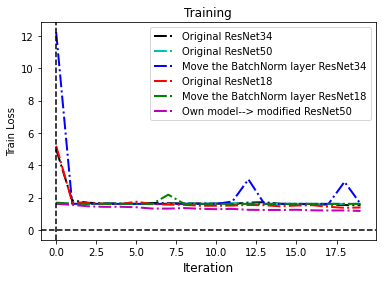

In [38]:
import matplotlib.pyplot as plt
import numpy as np

t_loss1 = torch.tensor(t_loss1, device = 'cpu')
t_loss2 = torch.tensor(t_loss2, device = 'cpu')
t_loss3 = torch.tensor(t_loss3, device = 'cpu')
t_loss4 = torch.tensor(t_loss4, device = 'cpu')
t_loss5 = torch.tensor(t_loss5, device = 'cpu')
t_loss6 = torch.tensor(t_loss6, device = 'cpu')

plt.plot(t_loss1, color ='k', linestyle = '-.', linewidth=2, label='Original ResNet34')
plt.plot(t_loss2, color ='c', linestyle = '-.', linewidth=2, label='Original ResNet50')
plt.plot(t_loss3, color ='b', linestyle = '-.', linewidth=2, label='Move the BatchNorm layer ResNet34')
plt.plot(t_loss4, color ='r', linestyle = '-.', linewidth=2, label='Original ResNet18')
plt.plot(t_loss5, color ='g', linestyle = '-.', linewidth=2, label='Move the BatchNorm layer ResNet18')
plt.plot(t_loss6, color ='m', linestyle = '-.', linewidth=2, label='Own model--> modified ResNet50')

#plt.plot(ylist, color ='blue', linestyle = '--')
plt.axvline(0, color='k', linestyle='--')# draw the axis y 
plt.axhline(0, color='k', linestyle='--')# draw the axis x
plt.title("Training by adjusting of learning rate")# name the diagram
plt.xlabel("Iteration", fontsize=12)# name the axis x
plt.ylabel("Train Accuracy")# name the axis y
plt.legend()
plt.show()# show the diagram

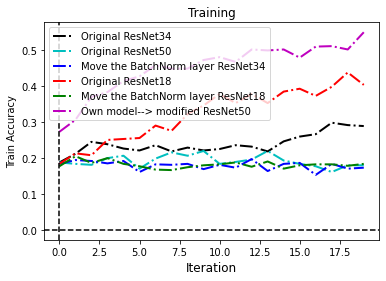

In [39]:
import matplotlib.pyplot as plt
import numpy as np

t_acc1 = torch.tensor(t_acc1, device = 'cpu')
t_acc2 = torch.tensor(t_acc2, device = 'cpu')
t_acc3 = torch.tensor(t_acc3, device = 'cpu')
t_acc4 = torch.tensor(t_acc4, device = 'cpu')
t_acc5 = torch.tensor(t_acc5, device = 'cpu')
t_acc6 = torch.tensor(t_acc6, device = 'cpu')

plt.plot(t_acc1, color ='k', linestyle = '-.', linewidth=2, label='Original ResNet34')
plt.plot(t_acc2, color ='c', linestyle = '-.', linewidth=2, label='Original ResNet50')
plt.plot(t_acc3, color ='b', linestyle = '-.', linewidth=2, label='Move the BatchNorm layer ResNet34')
plt.plot(t_acc4, color ='r', linestyle = '-.', linewidth=2, label='Original ResNet18')
plt.plot(t_acc5, color ='g', linestyle = '-.', linewidth=2, label='Move the BatchNorm layer ResNet18')
plt.plot(t_acc6, color ='m', linestyle = '-.', linewidth=2, label='Own model--> modified ResNet50')

#plt.plot(ylist, color ='blue', linestyle = '--')
plt.axvline(0, color='k', linestyle='--')# draw the axis y 
plt.axhline(0, color='k', linestyle='--')# draw the axis x
plt.title("Training by adjusting of learning rate")# name the diagram
plt.xlabel("Iteration", fontsize=12)# name the axis x
plt.ylabel("Train Accuracy")# name the axis y
plt.legend()
plt.show()# show the diagram

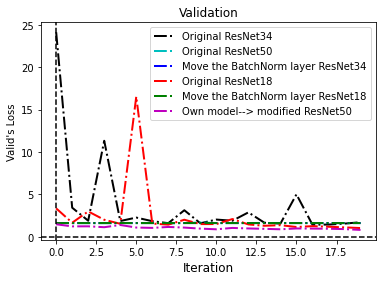

In [40]:
import matplotlib.pyplot as plt
import numpy as np
v_loss1 = torch.tensor(v_loss1, device = 'cpu')
v_loss2 = torch.tensor(v_loss2, device = 'cpu')
v_loss3 = torch.tensor(v_loss3, device = 'cpu')
v_loss4 = torch.tensor(v_loss4, device = 'cpu')
v_loss5 = torch.tensor(v_loss5, device = 'cpu')
v_loss6 = torch.tensor(v_loss6, device = 'cpu')

plt.plot(v_loss1, color ='k', linestyle = '-.', linewidth=2, label='Original ResNet34')
plt.plot(v_loss2, color ='c', linestyle = '-.', linewidth=2, label='Original ResNet50')
plt.plot(v_loss3, color ='b', linestyle = '-.', linewidth=2, label='Move the BatchNorm layer ResNet34')
plt.plot(v_loss4, color ='r', linestyle = '-.', linewidth=2, label='Original ResNet18')
plt.plot(v_loss5, color ='g', linestyle = '-.', linewidth=2, label='Move the BatchNorm layer ResNet18')
plt.plot(v_loss6, color ='m', linestyle = '-.', linewidth=2, label='Own model--> modified ResNet50')

#plt.plot(ylist, color ='blue', linestyle = '--')
plt.axvline(0, color='k', linestyle='--')# draw the axis y 
plt.axhline(0, color='k', linestyle='--')# draw the axis x
plt.title("Training by adjusting of learning rate")# name the diagram
plt.xlabel("Iteration", fontsize=12)# name the axis x
plt.ylabel("Train Accuracy")# name the axis y
plt.legend()
plt.show()# show the diagram

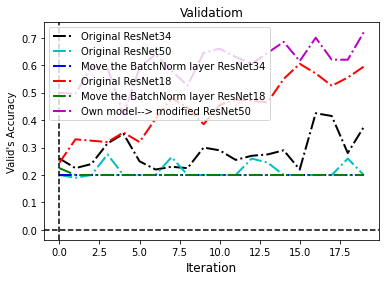

In [41]:
import matplotlib.pyplot as plt
import numpy as np
v_acc1 = torch.tensor(v_acc1, device = 'cpu')
v_acc2 = torch.tensor(v_acc2, device = 'cpu')
v_acc3 = torch.tensor(v_acc3, device = 'cpu')
v_acc4 = torch.tensor(v_acc4, device = 'cpu')
v_acc5 = torch.tensor(v_acc5, device = 'cpu')
v_acc6 = torch.tensor(v_acc6, device = 'cpu')

plt.plot(v_acc1, color ='k', linestyle = '-.', linewidth=2, label='Original ResNet34')
plt.plot(v_acc2, color ='c', linestyle = '-.', linewidth=2, label='Original ResNet50')
plt.plot(v_acc3, color ='b', linestyle = '-.', linewidth=2, label='Move the BatchNorm layer ResNet34')
plt.plot(v_acc4, color ='r', linestyle = '-.', linewidth=2, label='Original ResNet18')
plt.plot(v_acc5, color ='g', linestyle = '-.', linewidth=2, label='Move the BatchNorm layer ResNet18')
plt.plot(v_acc6, color ='m', linestyle = '-.', linewidth=2, label='Own model--> modified ResNet50')

#plt.plot(ylist, color ='blue', linestyle = '--')
plt.axvline(0, color='k', linestyle='--')# draw the axis y 
plt.axhline(0, color='k', linestyle='--')# draw the axis x
plt.title("Training by adjusting of learning rate")# name the diagram
plt.xlabel("Iteration", fontsize=12)# name the axis x
plt.ylabel("Train Accuracy")# name the axis y
plt.legend()
plt.show()# show the diagram

In [42]:
from sklearn.manifold import TSNE

for i, batch in enumerate(dataloaders['train']):
        images, labels = batch
        images = images.to(device)
        batch_size = images.size(0)
        labels = labels.to(device)
        logits = model(images)
        logits = logits.cpu().detach().numpy().reshape(batch_size, -1)
        labels = labels.cpu().detach().numpy()
        if i == 0:
            featureList = logits # 保存encode之后的特征
            labelsList = labels # 保存对应的label
        else:
            featureList = np.append(featureList, logits, axis=0)
            labelsList = np.append(labelsList, labels, axis=0)

print(featureList.shape, labelsList.shape)

(750, 5) (750,)


In [43]:
logits_encode = TSNE(n_components=2).fit_transform(featureList) # 接着使用tSNE进行降维
print(logits_encode.shape)

C:\Users\BiXY\anaconda3\envs\mmcv\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\BiXY\anaconda3\envs\mmcv\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(750, 2)


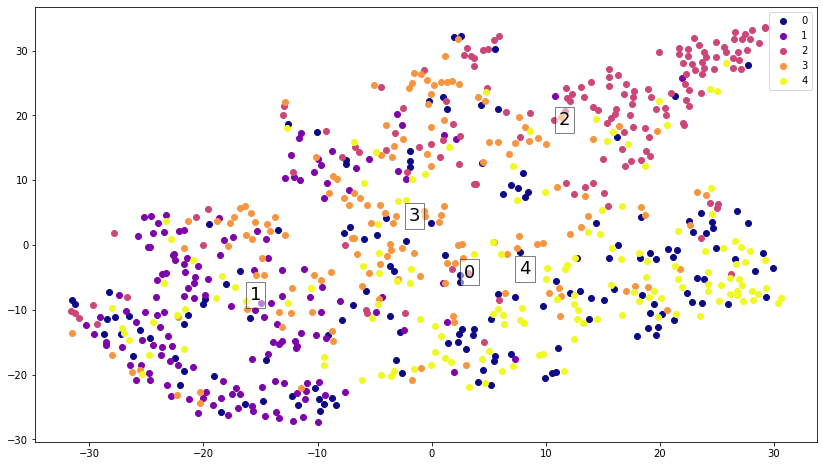

In [44]:
cmap = plt.get_cmap('plasma',5) # 数字与颜色的转换
# 获得可视化数据
v_x = logits_encode
v_y = labelsList
# 进行可视化
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
classes = [0,1,2,3,4]
for key in classes:
    ix = np.where(v_y==key)
    ax.scatter(v_x[ix][:,0], v_x[ix][:,1], color=cmap(key), label=key)
    ax.text(np.mean(v_x[ix][:,0]), np.mean(v_x[ix][:,1]), key, fontsize=18, bbox=dict(facecolor='white', alpha=0.5))
ax.legend()
plt.show()